In [21]:
!pip install python_speech_features

In [47]:
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from python_speech_features import mfcc, logfbank

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Flatten, MaxPool2D, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

### Plotting data of clean directory

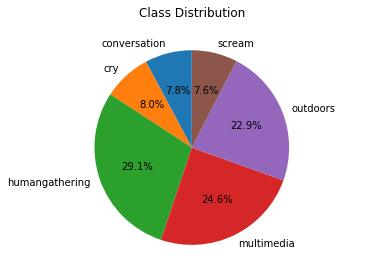

In [49]:
df=pd.read_csv('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/total00.csv')
df.set_index('audiofile', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/cleaned_data/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### data preparation in form of metrices to feed in Neural Network



In [50]:
# for taking samples from our audio dataset by dividing length of the total data by 10th of the second chunks|
n_samples= 2 * int(df['length'].sum()/0.1)
print(n_samples)

185880


In [51]:
prob_dist=class_dist/class_dist.sum()
print(prob_dist)

label
conversation      0.078119
cry               0.079846
humangathering    0.290688
multimedia        0.246469
outdoors          0.228861
scream            0.076016
Name: length, dtype: float64


In [52]:
choices= np.random.choice(class_dist.index,p=prob_dist)
print(classes)

['conversation', 'cry', 'humangathering', 'multimedia', 'outdoors', 'scream']


In [53]:
class Config:
    
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode=mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step= int(rate/10)

In [54]:
#  preparation of X and y metrices to be feeded in our model 

def build_rand_feat():
    X=[]
    y=[]
    _min,_max= float('inf'), -float('inf')
    
    for _ in tqdm(range(n_samples)):
        
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/cleaned_data/'+file)
        label=df.at[file,'label']
        rand_index=np.random.randint(0,wav.shape[0]-config.step)
        
        sample=wav[rand_index:rand_index+config.step]
        X_sample=mfcc(sample, rate, nfilt=config.nfilt, numcep=config.nfeat, nfft=config.nfft).T
        
#         X_sample=logfbank(signal,rate,nfft=config.nfft,nfilt=config.nfilt).T
        _min=min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        

        X.append(X_sample if config.mode=='conv' else X_sample.T)
        y.append(classes.index(label))
        
    X, y = np.array(X), np.array(y)
        
    X= (X - _min)/ (_max - _min)
        
#         print(X.shape)
    if config.mode=='conv' :
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode=='time':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
            
    y=to_categorical(y,num_classes=10)
        
    return X,y


###  CNN

In [55]:
config = Config(mode='conv')

In [56]:
def  get_conv_model():
    
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1), padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1), padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1), padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    return model
    
    
    

In [58]:
def get_recurrent_model():
    
#     shape of data for RNN is (n,time,feat)
    
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

In [59]:
if config.mode == 'conv':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2],1)
    model=get_conv_model()
    
elif config.mode == 'time':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2])
    model=get_recurrent_model()


  2%|▏         | 3053/185880 [00:17<16:12, 188.06it/s]


  4%|▎         | 6644/185880 [00:35<15:52, 188.21it/s]


  4%|▎         | 6914/185880 [00:36<12:38, 235.89it/s]W0730 11:22:30.508244 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

  6%|▌         | 10224/185880 [00:52<15:10, 192.83it/s]


  7%|▋         | 13164/185880 [01:06<18:43, 153.78it/s]W0730 11:23:00.676988 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

  7%|▋         | 13868/185880 [01:11<13:12, 217.15it/s]


 10%|▉         | 17678/185880 [01:27<11:32, 243.01it/s]


 10%|▉         | 18225/185880 [01:29<09:59, 279.54it/s]W0730 11:23:23.824046 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 12%|█▏        | 21572/185880 [01:43<11:38, 235.27it/s]


 12%|█▏        | 22496/185880 [01:46<09:30, 286.30it/s]W0730 11:23:41.007441 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 13%|█▎        | 23749/185880 [01:51<10:15, 263.22it/s]W0730 11:23:45.832764 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 14%|█▎        | 25340/185880 [01:57<09:50, 271.78it/s]


 16%|█▌        | 29312/185880 [02:12<09:29, 274.99it/s]


 18%|█▊        | 32992/185880 [02:25<09:54, 257.38it/s]W0730 11:24:20.075404 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 18%|█▊        | 33244/185880 [02:26<09:38, 263.94it/s]


 19%|█▉        | 36246/185880 [02:37<09:52, 252.74it/s]W0730 11:24:31.657177 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 20%|██        | 37196/185880 [02:40<12:03, 205.44it/s]


 22%|██▏       | 41170/185880 [02:55<09:13, 261.61it/s]


 24%|██▍       | 45185/185880 [03:10<08:21, 280.46it/s]


 26%|██▌       | 47737/185880 [03:19<08:04, 285.11it/s]W0730 11:25:13.351624 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 26%|██▌       | 47824/185880 [03:19<08:13, 279.54it/s]W0730 11:25:13.627374 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 26%|██▋       | 49056/185880 [03:23<07:59, 285.57it/s]


 28%|██▊       | 51405/185880 [03:32<07:58, 280.91it/s]W0730 11:25:26.412746 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 29%|██▊       | 53057/185880 [03:38<08:16, 267.30it/s]


 31%|███       | 57105/185880 [03:52<08:32, 251.50it/s]


 33%|███▎      | 61159/185880 [04:07<08:13, 252.94it/s]


 33%|███▎      | 62195/185880 [04:10<08:13, 250.49it/s]W0730 11:26:05.155204 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 34%|███▍      | 63164/185880 [04:14<07:38, 267.72it/s]W0730 11:26:08.863854 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 35%|███▍      | 64855/185880 [04:21<07:22, 273.22it/s]


 37%|███▋      | 68930/185880 [04:35<07:36, 256.19it/s]


 39%|███▉      | 72988/185880 [04:49<06:57, 270.69it/s]


 40%|████      | 75168/185880 [04:57<07:04, 260.76it/s]W0730 11:26:52.009565 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 41%|████▏     | 76911/185880 [05:04<06:31, 278.07it/s]


 44%|████▎     | 80990/185880 [05:18<06:20, 275.97it/s]


 46%|████▌     | 85025/185880 [05:33<06:19, 265.89it/s]


 48%|████▊     | 88826/185880 [05:46<05:54, 273.61it/s]W0730 11:27:40.969248 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 48%|████▊     | 88995/185880 [05:47<06:03, 266.87it/s]


 50%|█████     | 93054/185880 [06:01<05:33, 278.36it/s]


 51%|█████     | 94159/185880 [06:05<05:12, 293.40it/s]W0730 11:27:59.771159 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 51%|█████     | 94573/185880 [06:06<05:24, 280.95it/s]W0730 11:28:01.249954 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 52%|█████▏    | 96767/185880 [06:15<05:42, 259.92it/s]W0730 11:28:09.844908 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.



 53%|█████▎    | 98688/185880 [06:22<05:10, 280.69it/s]W0730 11:28:16.732987 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 54%|█████▍    | 100675/185880 [06:29<05:43, 248.37it/s]


 56%|█████▌    | 104410/185880 [06:44<07:36, 178.61it/s]


 57%|█████▋    | 106399/185880 [06:52<04:53, 270.83it/s]W0730 11:28:46.832944 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 58%|█████▊    | 108248/185880 [07:00<05:48, 223.04it/s]


 60%|██████    | 112155/185880 [07:15<04:42, 261.32it/s]


 62%|██████▏   | 116125/185880 [07:29<04:05, 283.68it/s]


 65%|██████▍   | 119962/185880 [07:44<04:00, 274.32it/s]


 66%|██████▋   | 123521/185880 [07:56<03:37, 286.06it/s]W0730 11:29:51.249609 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 67%|██████▋   | 123868/185880 [07:58<03:49, 270.72it/s]


 69%|██████▊   | 127739/185880 [08:14<05:51, 165.40it/s]


 70%|██████▉   | 129493/185880 [08:45<17:16, 54.38it/s]


 71%|███████   | 131284/185880 [09:06<16:58, 53.59it/s]


 72%|███████▏  | 133697/185880 [09:24<04:03, 214.19it/s]


 72%|███████▏  | 133978/185880 [09:26<03:56, 219.76it/s]W0730 11:31:20.676372 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 73%|███████▎  | 135632/185880 [09:37<03:36, 232.61it/s]W0730 11:31:32.307660 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 73%|███████▎  | 136498/185880 [09:45<03:57, 207.69it/s]


 75%|███████▌  | 139869/185880 [10:03<03:25, 224.08it/s]


 77%|███████▋  | 143480/185880 [10:22<03:07, 226.65it/s]


 79%|███████▉  | 147277/185880 [10:37<02:26, 263.71it/s]


 81%|████████▏ | 151110/185880 [10:52<02:08, 271.04it/s]


 83%|████████▎ | 154918/185880 [11:06<02:01, 254.32it/s]W0730 11:33:00.629800 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 83%|████████▎ | 154951/185880 [11:06<01:54, 270.70it/s]


 85%|████████▌ | 158875/185880 [11:20<01:43, 259.98it/s]


 88%|████████▊ | 162826/185880 [11:35<01:24, 273.69it/s]


 88%|████████▊ | 164335/185880 [11:40<01:22, 259.91it/s]W0730 11:33:34.757444 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 89%|████████▉ | 165510/185880 [11:44<01:12, 280.74it/s]W0730 11:33:39.104245 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 90%|████████▉ | 166593/185880 [11:49<01:18, 245.44it/s]


 91%|█████████ | 168275/185880 [11:56<00:59, 297.90it/s]W0730 11:33:50.882974 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 91%|█████████▏| 169911/185880 [12:12<01:35, 167.50it/s]W0730 11:34:06.944478 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.



 92%|█████████▏| 171329/185880 [12:21<01:04, 226.45it/s]W0730 11:34:15.460695 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 93%|█████████▎| 173194/185880 [12:31<01:32, 136.77it/s]


 95%|█████████▍| 176298/185880 [12:49<00:39, 240.81it/s]


 97%|█████████▋| 180058/185880 [13:05<00:26, 217.02it/s]


 98%|█████████▊| 182749/185880 [13:18<00:15, 205.19it/s]W0730 11:35:12.471194 140110462297920 sigproc.py:82] frame length (1103) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid.

 99%|█████████▉| 183889/185880 [13:24<00:12, 159.32it/s]


100%|██████████| 185880/185880 [13:46<00:00, 224.81it/s]

ValueError: could not broadcast input array from shape (13,9) into shape (13)

In [46]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

NameError: name 'y' is not defined

In [ ]:
model.fit(x,y,epochs=5,batch_size=32,shuffle=True,class_weight=class_weight)

### RNN

In [0]:
config = Config(mode='time')
if config.mode == 'conv':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2],1)
    model=get_conv_model()
    
elif config.mode == 'time':
    x,y= build_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=(x.shape[1],x.shape[2])
    model=get_recurrent_model()

100%|██████████| 37956/37956 [02:23<00:00, 265.21it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 16)             528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 8)              136       
__________

In [0]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

In [0]:
model.fit(x,y,epochs=15,batch_size=32,shuffle=True,class_weight=class_weight)

Epoch 1/15
37956/37956 [==============================] - 46s 1ms/step - loss: 0.4099 - acc: 0.8564
Epoch 2/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.3751 - acc: 0.8698
Epoch 3/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.3486 - acc: 0.8788
Epoch 4/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.3189 - acc: 0.8912
Epoch 5/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.3081 - acc: 0.8954
Epoch 6/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.2866 - acc: 0.9034
Epoch 7/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.2731 - acc: 0.9075
Epoch 8/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.2631 - acc: 0.9116
Epoch 9/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.2535 - acc: 0.9142
Epoch 10/15
37956/37956 [==============================] - 45s 1ms/step - loss: 0.2370 - acc: 0.9198